In [1]:
import pandas as pd
data=pd.read_csv('banladesh.csv',index_col='ObservationDate',parse_dates=True)
data.head()

,Confirmed
ObservationDate,
2020-03-08,3
2020-03-09,3
2020-03-10,3
2020-03-11,3
2020-03-12,3


In [2]:
import math
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten,LSTM,ConvLSTM2D
from keras.layers import Dense,MaxPooling1D,Conv1D,TimeDistributed
from tensorflow.keras.initializers import GlorotUniform, HeNormal
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(101)


In [3]:
def train_test_split(data,n_test):
    return data[:-n_test],data[-n_test:]

def series_to_supervised(data,n_in,n_out=1):
    df=pd.DataFrame(data)
    cols=list()
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
    
    for i in range(0,n_out):
        cols.append(df.shift(-i))
    
    agg=pd.concat(cols,axis=1)
    agg.dropna(inplace=True)
    return agg.values

def model_fit(train,config):

    n_seq,n_steps, n_filters, n_kernel,n_nodes, n_epochs, n_batch= config
    n_input=n_seq*n_steps

    data=series_to_supervised(train,n_input)
    
    train_x, train_y=data[:,:-1],data[:,-1]
    train_x=train_x.reshape((train_x.shape[0],n_seq,n_steps,1))
    model=Sequential()
    model.add(TimeDistributed(Conv1D(filters=n_filters,kernel_size=n_kernel,activation='relu',input_shape=(None,n_steps,1),kernel_initializer=HeNormal()))) #,padding='same'
    #model.add(TimeDistributed(Conv1D(filters=n_filters,kernel_size=n_kernel,activation='relu'))) #,padding='same'
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes,activation='relu'))
    model.add(Dense(n_nodes,activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse',optimizer='adam')

    model.fit(train_x,train_y,epochs=n_epochs, batch_size=n_batch,verbose=0)
    return model

def model_predict(model,history,config):
    n_seq,n_steps,_,_,_,_,_=config
    n_input=n_seq*n_steps
    x_input=np.array(history[-n_input:]).reshape((1,n_seq,n_steps,1))
    #print(x_input)
    y_hat=model.predict(x_input,verbose=0)
    return y_hat[0]

def measure_rmse(actual,prediction):
    return math.sqrt(metrics.mean_squared_error(actual,prediction,squared=False))

def walk_forward_validation(data,n_test,cfg):
    predictions=list()
    train,test=train_test_split(data,n_test)

    model=model_fit(train,cfg)

    history=[x for x in train]
    
    for i in range(len(test)):
        yhat=model_predict(model,history,cfg)
        predictions.append(yhat.round())
        history.append(test[i])
    error=measure_rmse(test,predictions)
    print(" > %.3f " %error)
    return error
def repeat_evaluate(data,config,n_test,n_repeats=5):
    scores=[walk_forward_validation(data,n_test,config) for _ in range(int(n_repeats))]
    return scores
def summarize_scores(name,scores):
    scores_m, score_std= np.mean(scores), np.std(scores)
    print("%s: %.3f RMSE (+/- %3f" %(name,scores_m,score_std))
    plt.boxplot(scores)
    plt.show()


In [4]:
data=data.values

### without round the number the average is 204 and the variation is 53.38

 > 162.474 
 > 105.560 
 > 72.377 
 > 70.472 
 > 52.724 
Persistence: 92.721 RMSE (+/- 38.830105


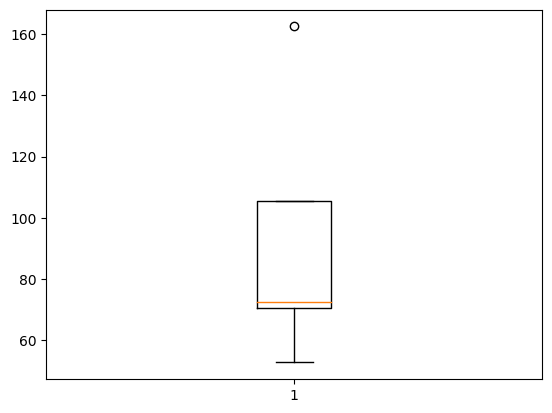

In [5]:
n_test=164
config=[3,4,128,3,100,100,100]
scores=repeat_evaluate(data,config,n_test)

summarize_scores('Persistence',scores)

In [9]:
# from numpy.random import seed
# seed(1)
# import tensorflow
tensorflow.random.set_seed(105)
predictions=list()
train,test=train_test_split(data,n_test)

model=model_fit(train,config)

history=[x for x in train]

for i in range(len(test)):
    yhat=model_predict(model,history,config)
    predictions.append(yhat.round())
    history.append(test[i])
error=measure_rmse(test,predictions)
print(" > %.3f " %error)

 > 56.850 


In [10]:
data_2=pd.read_csv('banladesh.csv',index_col='ObservationDate',parse_dates=True)
data_2.head()

,Confirmed
ObservationDate,
2020-03-08,3
2020-03-09,3
2020-03-10,3
2020-03-11,3
2020-03-12,3


In [11]:
prediction_np=list()
for i in range(test.shape[0]):
    prediction_np.append(predictions[i][0].round())

In [13]:
test_np=list()
for i in range(test.shape[0]):
    test_np.append(test[i][0])

In [14]:
test_np=np.array(test_np)
prediction_np=np.array(prediction_np)
prediction_data=pd.DataFrame({'test':test_np,'predict':prediction_np})
prediction_data.head()

,test,predict
0,1591093,1591272.0
1,1592209,1592541.0
2,1593700,1593527.0
3,1595931,1594977.0
4,1598389,1597581.0


<Axes: >

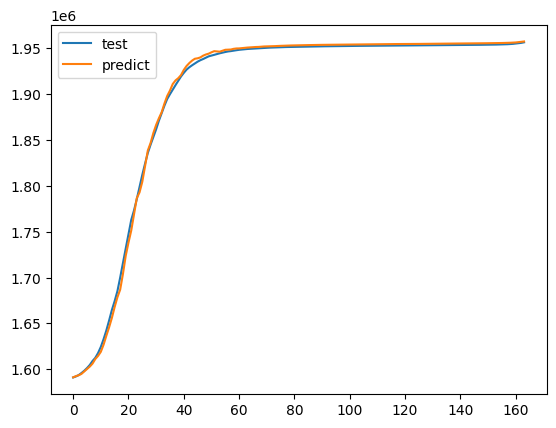

In [15]:
prediction_data.plot()

In [16]:
new_predict=pd.concat([prediction_data,pd.DataFrame(data_2.index[-164:])],axis=1)

In [47]:
import matplotlib
matplotlib.rc_file_defaults()

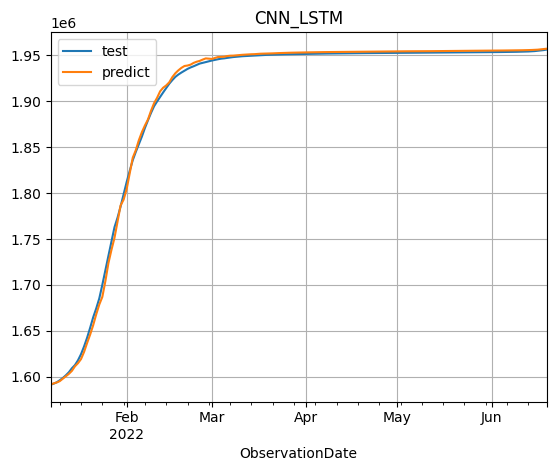

In [49]:
from matplotlib import pyplot as plt
# plt.rcParams["figure.figsize"] = [2, 1.5]
# plt.rcParams["figure.autolayout"] = False
plt.rcParams["savefig.dpi"] = 360
new_predict.plot(x='ObservationDate')
plt.title('CNN_LSTM')
plt.grid()